In [78]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-10-12 15:07:45.953441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-12 15:07:45.960346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-12 15:07:45.961477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-12 15:07:47.332201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-12 15:07:47.332288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not ident

In [79]:
from __future__ import print_function
from tensorflow import keras
import numpy as np
import cv2

import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [118]:
seed = 123
zoom = 2
downscale_fact = 2

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 200
image_width = 200

images_path = '../images'
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=zoom_range,
    horizontal_flip=True,
    validation_split=0.2,
    # featurewise_center=True
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='training'
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='validation'
)


def preprocess_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], image_height, image_width, 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = preprocess_img(batch[i])
        yield batch_crops, batch_crops

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)



Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


In [119]:
print(train_ds_prep)
print(np.max(next(train_ds_prep)[0]))
print('asd', next(train_ds_prep)[0].shape)
print('asd', next(train_ds_prep)[1].shape)
train_ds.reset()

<generator object preprocess_generator at 0x7f52c43372e0>
1.0
asd (32, 200, 200, 3)
asd (32, 200, 200, 3)


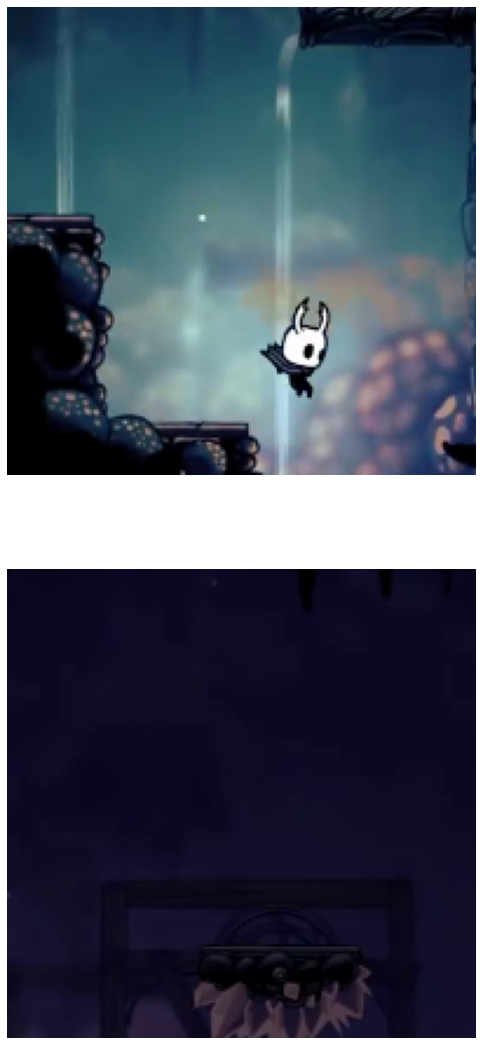

In [120]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [147]:
import tensorflow
from keras import mixed_precision
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, Dropout, BatchNormalization, Conv2DTranspose
from keras.layers import UpSampling2D, concatenate
from keras.models import Model, Sequential
from keras.activations import softmax
from keras.regularizers import l2


def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))

# outdated stuff (grayscale)
'''
def create_big_compression_model_2_outdated(image_width, image_height):
    model = Sequential([
        Conv2D(input_shape=(image_width, image_height, 1), filters=16, kernel_size=(4, 4), activation='relu', padding='same'),
        MaxPooling2D((3, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        MaxPooling2D((2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        MaxPooling2D((2, 2), name='encoded', dtype='float16'),
        #Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        #MaxPooling2D((2, 2), name='encoded', dtype='float16'),

        #Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #UpSampling2D((2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        UpSampling2D((2, 2)),
        ZeroPadding2D(((1, 0), (1, 0))),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        UpSampling2D((2, 2)),
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        UpSampling2D((3, 3)),
        ZeroPadding2D(((1, 1), (1, 1))),
        Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', name='decoded'),
    ])

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

def create_mnist_compression_model_outdated(image_width, image_height):
    tensorflow.random.set_seed(0)
    inputs = Input(shape=(image_width, image_height, 1))

    # Encoder (convolutional base)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    print(("shape of encoded", K.int_shape(encoded)))



    # Decoder (upsamling)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, kernel_size=(5, 5), padding='same')(x)
    print(("shape of decoded", K.int_shape(decoded)))

    return Model(inputs, decoded)

def create_improved_baseline_model_complex_outdated(image_width, image_height):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', input_shape=(image_width, image_height, 1)))
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2D(40, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', name='encoded', dtype='float16'))
    model.add(Conv2DTranspose(40, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(ZeroPadding2D(((1, 0), (1, 0))))
    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(ZeroPadding2D(((1, 0), (1, 0))))
    model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model
'''

# 12x compression for RGB images
def create_improved_baseline_model_12x_comp(image_width, image_height):
    ### Encoder ###

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_width, image_height, 3)))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))
    #model.add(Dropout(.2))

    '''model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))'''

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    '''model.add(Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))'''

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))


    ### Decoder ###

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='valid', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    '''model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))'''

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    '''model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))'''

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

'''# 4x compression for RGB images, same as 12x but the number of filters are multiplied by 3
def create_improved_baseline_model_4x_comp(image_width, image_height):
    model = Sequential()
    model.add(Conv2D(48, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_width, image_height, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Conv2D(96, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(192, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Conv2D(96, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='encoded', dtype='float16'))

    model.add(Conv2DTranspose(192, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(96, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(48, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model'''

def my_conv(x, filters, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer='he_normal', name=None):
  x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name=name)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def my_convTrans(x, filters, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer='he_normal', name=None):
  x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name=name)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

# complex stuff and unet tmp (grayscale)
'''
def create_improved_baseline_model_complex(image_width, image_height):
    input = Input(shape=(image_height, image_width, 1))
    x = my_conv(input, 16, kernel_size=(7, 7))
    x = my_conv(x, 32)
    x = my_conv(x, 32)
    x = Dropout(.2)(x)
    x = my_conv(x, 64, padding='valid')
    x = Dropout(.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='encoded', dtype='float16')(x)

    x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(16, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded')(x)

    model = Model(input, x)

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model


def create_improved_baseline_model_complex_2(image_width, image_height):
    input = Input(shape=(image_height, image_width, 1))
    x = my_conv(input, 16, kernel_size=(7, 7))
    x = my_conv(x, 32)
    x = my_conv(x, 32)
    x = Dropout(.2)(x)
    x = my_conv(x, 64, padding='valid')
    x = Dropout(.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='encoded', dtype='float16')(x)

    x = my_convTrans(x, 128)
    x = my_convTrans(x, 64, padding='valid')
    x = my_convTrans(x, 32)
    x = my_convTrans(x, 16, kernel_size=(7, 7))
    x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded')(x)

    model = Model(input, x)

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

def create_unet_tmp(image_width, image_height):
    # Encoder
    encoder_input = Input(shape=(image_width, image_height, 1))
    conv1 = my_conv(encoder_input,filters=16, kernel_size=7)
    conv2 = my_conv(conv1, filters=32)
    conv3 = my_conv(conv2, filters=64)
    encoded = my_conv(conv3, filters=32, padding='valid', name='encoded')

    encoder = Model(encoder_input, encoded)

    # Decoder
    decoder_input = Input(shape=(12, 12, 32))
    up7 = my_convTrans(decoder_input,filters=64, padding='valid')
    merge7 = concatenate([conv3, up7], axis = 3)
    up8 = my_convTrans(merge7,filters=32)
    merge8 = concatenate([conv2, up8], axis = 3)
    up9 = my_convTrans(merge8,filters=16, kernel_size=7)
    merge9 = concatenate([conv1, up9], axis = 3)
    decoded = Conv2DTranspose(1, kernel_size=3, strides=(2, 2), activation='sigmoid', padding='same')(merge9)

    decoder = Model(decoder_input, decoded)

    # Autoencoder
    auto_input = Input(shape=(image_width, image_height, 1))
    encoded = encoder(auto_input)
    decoded = decoder(encoded)
    autoencoder = Model(auto_input, decoded)

    return encoder, decoder, autoencoder
'''


# U-Net for RGB images
def create_unet(image_width, image_height):
    # Encoder
    encoder_input = Input(shape=(image_width, image_height, 3))
    conv1 = my_conv(encoder_input,filters=16, kernel_size=7)
    conv2 = my_conv(conv1, filters=32)
    conv3 = my_conv(conv2, filters=64)
    encoded = my_conv(conv3, filters=32, padding='valid', name='encoded')

    # Decoder
    up7 = my_convTrans(encoded,filters=64, padding='valid', name='decoder_input')
    merge7 = concatenate([conv3, up7], axis = 3)
    up8 = my_convTrans(merge7,filters=32)
    merge8 = concatenate([conv2, up8], axis = 3)
    up9 = my_convTrans(merge8,filters=16, kernel_size=7)
    merge9 = concatenate([conv1, up9], axis = 3)
    decoded = Conv2DTranspose(3, kernel_size=3, strides=(2, 2), activation='sigmoid', padding='same')(merge9)

    model = Model(encoder_input, decoded)

    return model

# mixed_precision.set_global_policy('mixed_float16')
# mixed_precision.set_global_policy('float32')

In [148]:
def split_autoencoder(autoencoder):
    # Get encoder
    encoder = Model(inputs=autoencoder.layers[0].input, outputs=autoencoder.get_layer('encoded').output)
    decoder_input = Input(shape=(12, 12, 32))
    decoder = Model(inputs=autoencoder.get_layer('decoder_input').input, outputs=autoencoder.layers[-1].output)

    return encoder, decoder

In [149]:
autoencoder = create_improved_baseline_model_12x_comp(image_width, image_height)
#autoencoder = create_unet(image_width, image_height)
# encoder, decoder = split_autoencoder(autoencoder)
autoencoder.summary()

('shape of encoded', (None, 12, 12, 32))
('shape of decoded', (None, 200, 200, 3))
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 100, 100, 16)      2368      
                                                                 
 batch_normalization_128 (Ba  (None, 100, 100, 16)     64        
 tchNormalization)                                               
                                                                 
 activation_148 (Activation)  (None, 100, 100, 16)     0         
                                                                 
 conv2d_126 (Conv2D)         (None, 50, 50, 32)        4640      
                                                                 
 batch_normalization_129 (Ba  (None, 50, 50, 32)       128       
 tchNormalization)                                               
                                    

In [150]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss=ssim_loss)
#autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss='binary_crossentropy')
# autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.05), loss=ssim_loss)

In [ ]:
# loss: 0.0676 - val_loss: 0.0727
# after 160 epochs - loss 0.0392

# 4x
# loss: 60 epochs - 0.1301
# loss: > 1000 epochs - 0.0784
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError())
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss=losses.MeanSquaredError())
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=55,
                verbose=1)

# autoencoder.fit(train_ds_mapped, epochs=1,
#                 validation_data=test_ds_mapped, verbose=1)

Epoch 1/55
106/106 [==============================] - 170s 1s/step - loss: 0.2623 - val_loss: 0.1824
Epoch 2/55
106/106 [==============================] - 162s 2s/step - loss: 0.1047 - val_loss: 0.1397
Epoch 3/55
106/106 [==============================] - 174s 2s/step - loss: 0.0926 - val_loss: 0.0986
Epoch 4/55
106/106 [==============================] - 183s 2s/step - loss: 0.0843 - val_loss: 0.1095
Epoch 5/55
106/106 [==============================] - 186s 2s/step - loss: 0.0801 - val_loss: 0.0867
Epoch 6/55
106/106 [==============================] - 190s 2s/step - loss: 0.0764 - val_loss: 0.0724
Epoch 7/55
106/106 [==============================] - 206s 2s/step - loss: 0.0733 - val_loss: 0.0877
Epoch 8/55
106/106 [==============================] - 201s 2s/step - loss: 0.0708 - val_loss: 0.0830
Epoch 9/55
106/106 [==============================] - 216s 2s/step - loss: 0.0695 - val_loss: 0.0682
Epoch 10/55
106/106 [==============================] - 235s 2s/step - loss: 0.0684 - val_lo

In [60]:
# Saving the model:
autoencoder.save('../model-saves/improved-12x-RGB-v2/')

INFO:tensorflow:Assets written to: ../model-saves/improved-12x-RGB-v2/assets


INFO:tensorflow:Assets written to: ../model-saves/improved-12x-RGB-v2/assets


In [ ]:
# Loading the model
# autoencoder = keras.models.load_model('../model-saves/conv2dtrans/model-save-170', custom_objects={
#     'ssim_loss': ssim_loss
# })

In [278]:
# Saving the model:
# autoencoder.save('../model-saves/tmp/')

INFO:tensorflow:Assets written to: ../model-saves/conv2dtrans-4x/assets


INFO:tensorflow:Assets written to: ../model-saves/conv2dtrans-4x/assets


In [7]:
# Loading the model
# autoencoder = keras.models.load_model('../model-saves/conv2dtrans/model-save-170', custom_objects={
#     'ssim_loss': ssim_loss
# })

1/1 [==============================] - 0s 73ms/step


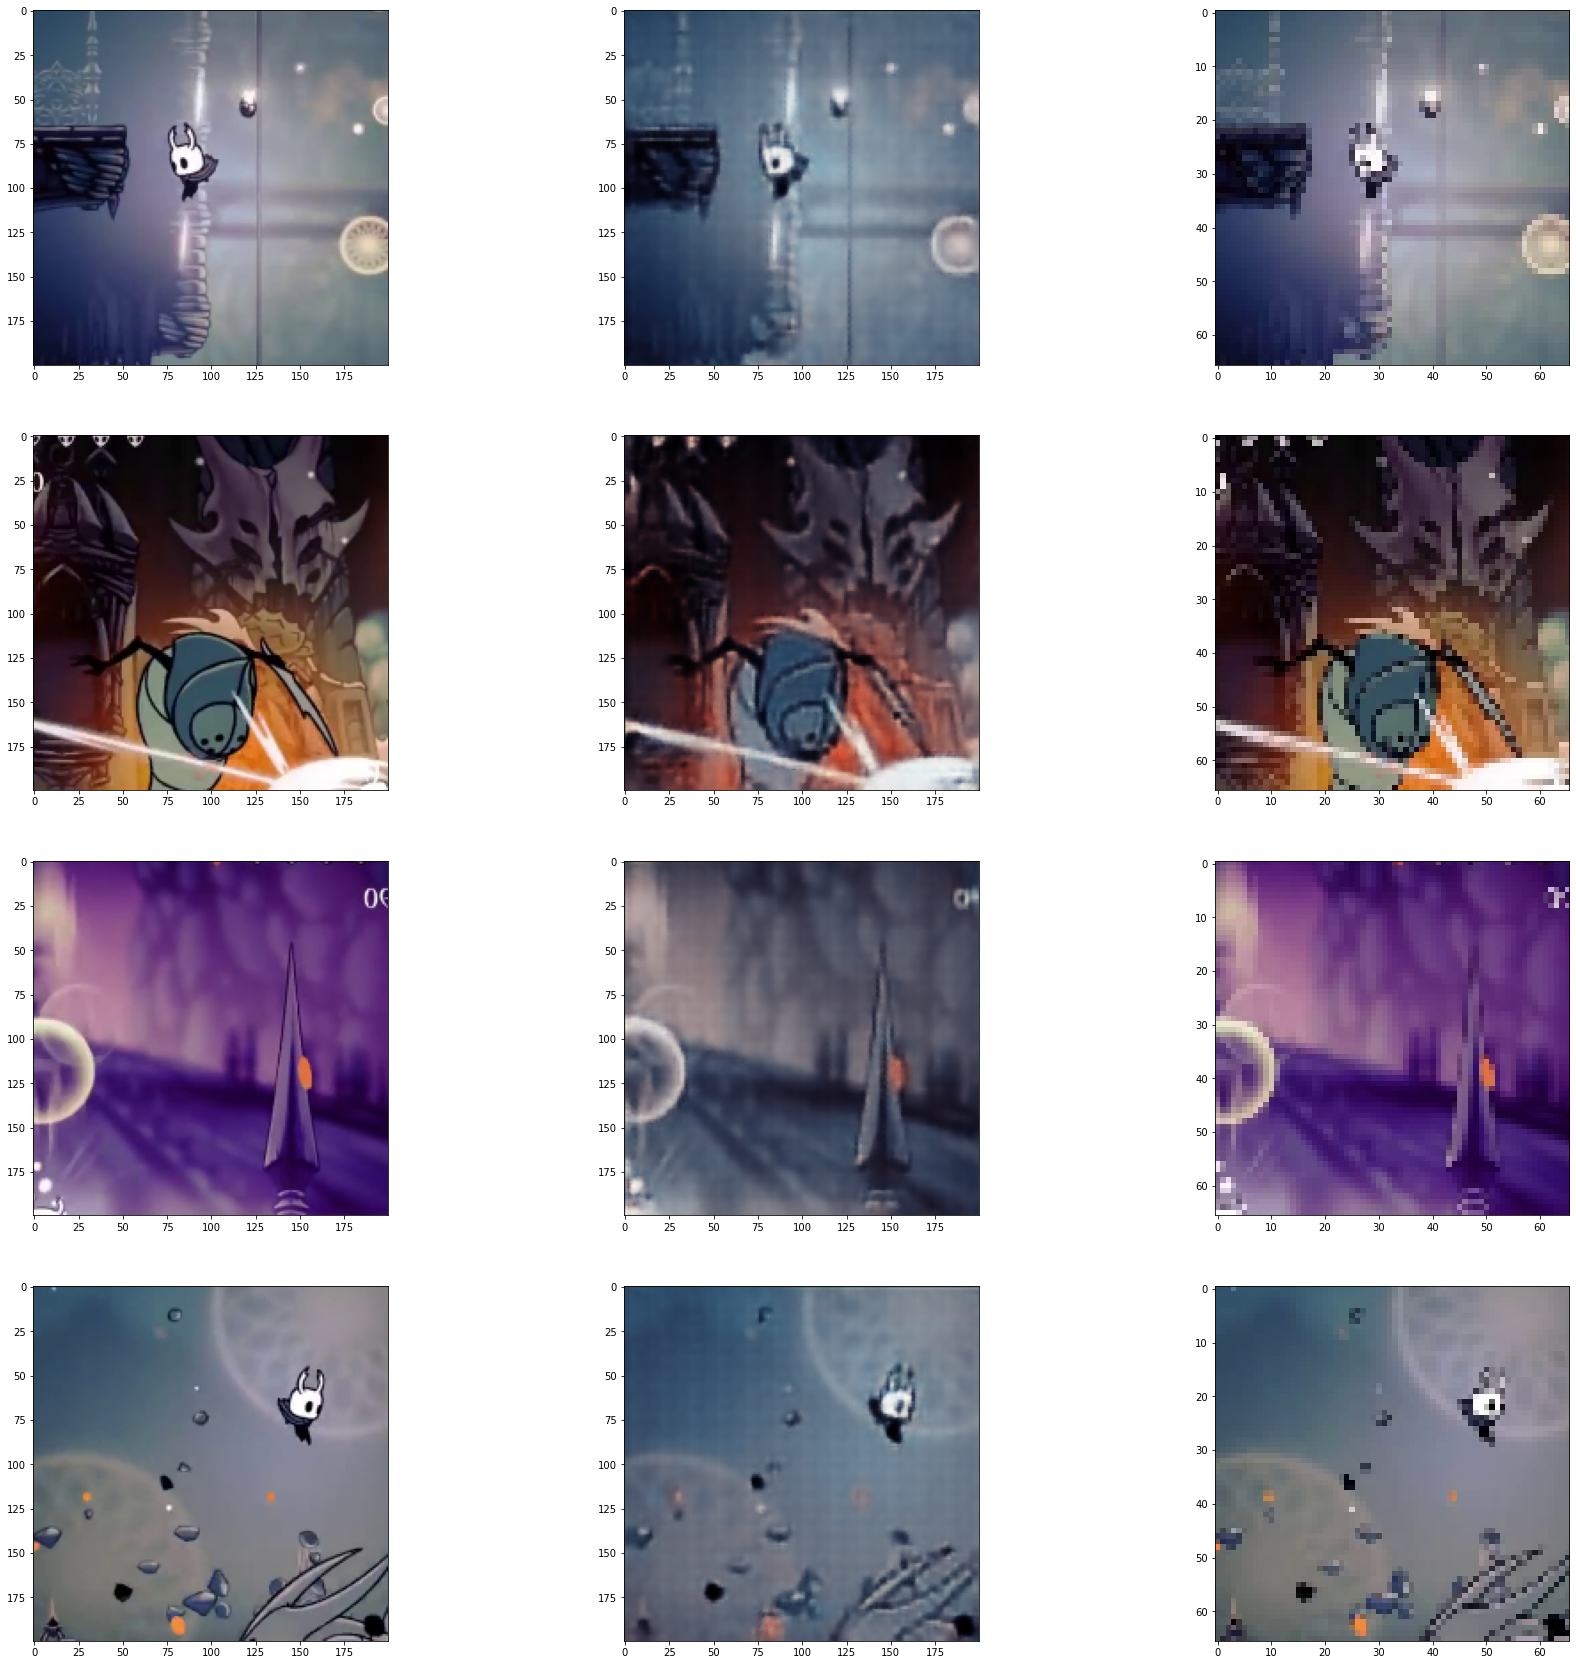

In [63]:
from matplotlib.pyplot import axes
import numpy as np

img_number = 4
test_images = next(test_ds_prep)[0][:img_number]
decoded_imgs = autoencoder.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(in_img, (in_img.shape[0] // 3, in_img.shape[1] // 3))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')